In [3]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [5]:
# read in our data
url = "https://raw.githubusercontent.com/SamIlic/Stat479_Project/master/Data/prices.csv"
df_features = pd.read_csv(url)

df_features['date'] = pd.to_datetime(df_features['date'])
df_features.head()

,date,Ticker,open,close,low,high,volume
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000


In [6]:
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['date', 'Ticker', 'close']].copy()
        # generate dataframe to shift index by i day. 415 is number of stocks
        df_lag['date'] = df_lag['date'].shift(-i*415)
        df_lag.columns = ['date', 'Ticker', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['date', 'Ticker'], right_on = ['date', 'Ticker'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [11]:
df_features = create_lag_features(df_features, 3)

# Sanity Check
df_temp = df_features.loc[df_features['Ticker'] == "AAPL"]
df_temp.head()

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400,NaN,NaN,NaN,NaN
417,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200,0.172887,NaN,NaN,NaN
832,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000,-1.590633,0.172887,NaN,NaN
1247,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800,-0.184858,-1.590633,0.172887,NaN
1662,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700,0.664833,-0.184858,-1.590633,0.172887


In [12]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)

In [13]:
# finds all unique stocks
uniq_stocks = set(df_features['Ticker'])

In [16]:
# training data is anything less than 2016
X_train = df_features.loc[(df_features['date'] < '2016-01-01'),:]
y_train = X_train['Today']

# sam might need these column for feature engineering
X_train.drop(['open','close','low','high','Today'], axis = 1, inplace = True)

# testing data is 2016
X_test = df_features.loc[(df_features['date'] > '2015-12-31'), :]
y_test = X_test['Today']

# sam might need these column for feature engineering
X_test.drop(['open','close','low','high','Today'], axis = 1, inplace = True)

In [17]:
X_train.head(10)

,date,Ticker,volume,lag1,lag2,lag3
1660,2010-01-08,AAL,12760000,2.946955,-4.143126,11.320755
1661,2010-01-08,AAP,960300,-0.024702,0.871956,-0.594359
1662,2010-01-08,AAPL,111902700,-0.184858,-1.590633,0.172887
1663,2010-01-08,ABC,4277500,-1.603669,-0.945537,-0.713474
1664,2010-01-08,ABT,12148600,0.828423,0.555350,-0.807929
1665,2010-01-08,ADBE,5429200,-1.940457,-0.212207,1.644651
1666,2010-01-08,ADI,2393100,-0.792142,-0.189760,-0.157875
1667,2010-01-08,ADM,6264700,-1.045624,-0.252845,0.540197
1668,2010-01-08,ADS,1106500,0.919369,0.499850,0.197295
1669,2010-01-08,ADSK,4648300,0.552486,0.237338,-1.519279


In [18]:
# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
# Final model we should use say 100
# when training, for the purpose of time, we should use <=10
X_train_one = X_train.loc[X_train['Ticker'] == 'MSFT', :]
y_train_one = list(y_train[X_train_one.index])
X_train_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

X_test_one = X_test.loc[X_test['Ticker'] == 'MSFT', :]
y_test_one = list(y_test[X_test_one.index])
X_test_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

In [19]:
# random forest regression
rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 10)
rf.fit(X_train_one, y_train_one)
print(mean_squared_error(y_test_one, rf.predict(X_test_one)))

2.295970891271329


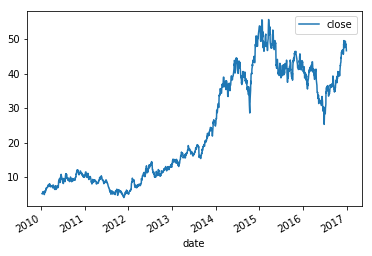

In [22]:
import matplotlib.pyplot as plt

a = df_features.loc[df_features.loc[:,'Ticker'] == 'AAL', ['date', 'close']]
a.plot(x = 'date', y = 'close')
plt.show()